In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on July 30 2018
@author: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)    
    

In [2]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}


<IPython.core.display.Javascript object>

In [3]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [33]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel

# scipy and skimage
from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

In [151]:
#initalize different classes and functions 
# first 3 classes (Pupil, PupilFactory and PFSPupilFactory are taken almost directly from the code written by J. Meyers for the HSC projects, with modifications to this project)
# ZernikeFitter_PFS class creates images
# LN_PFS_single class contains functions which I use when fitting best fit parameters. Single denotes that this class is just for fitting a single image, i.e.,
# not for fitting multiple images at different values of defocus, which is 
# LNP_PFS class just returns zero - I use it for parallel tempering when fittign paramters on cluster, but not used here
# on the end are several 'free' functions which I use in ZernikeFitter_PFS and LN_PFS_single classes
__all__ = ['PupilFactory', 'Pupil']

class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale

class PupilFactory(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,slitFrac,slitFrac_dy,minorAxis,pupilAngle):
        """!Construct a PupilFactory.

        @params others
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        #self.illumminatedFrac=illumminatedFrac
        self.pupilScale = pupilSize/npix
        self.slitFrac=slitFrac
        self.slitFrac_dy=slitFrac_dy
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        np.save(TESTING_FOLDER+'fullPupililluminated',illuminated) 
        return Pupil(illuminated, self.pupilSize, self.pupilScale)       

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False
        
    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        np.save(TESTING_FOLDER+'selfu',self.u) 
        np.save(TESTING_FOLDER+'selfv',self.v) 
        np.save(TESTING_FOLDER+'cutCircleExteriorilluminated',pupil.illuminated) 
        #return Pupil(illuminated, self.pupilSize, self.pupilScale)
    
    def _cutEllipseExterior(self, pupil, p0, r, b, thetarot):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Ellipse region radius = major axis
        @param[in] b      Ellipse region radius = minor axis
        @param[in] thetarot   Ellipse region rotation
        """
        
        #a=selfu[0][0]
        #b=selfu[0][0]*0.8
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        theta=np.arctan(self.u/self.v)+thetarot
        
        #illuminated = np.ones(self.u.shape, dtype=np.bool)
        pupil.illuminated[r2 > r**2*b**2/(b**2*(np.cos(theta))**2+r**2*(np.sin(theta))**2)] = False
        np.save(TESTING_FOLDER+'fullPupililluminated',pupil.illuminated) 
        #return Pupil(illuminated, self.pupilSize, self.pupilScale)

    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        

class PFSPupilFactory(PupilFactory):
    """!Pupil obscuration function factory for PFS 
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac,slitFrac,slitFrac_dy,minorAxis,pupilAngle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac,slitFrac,slitFrac_dy,minorAxis,pupilAngle)
        self.minorAxis=minorAxis
        self.pupilAngle=pupilAngle
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        # subaruRadius = (self.pupilSize/2)*self.illumminatedFrac
        subaruRadius = (self.pupilSize/2)*1

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        slitFrac = self.slitFrac 
        subaruSlit = slitFrac*subaruRadius
        # meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 
        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius
        
        slitFrac_dy = self.slitFrac_dy 


        
        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 2.62 / 1000 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98


        hscPlateScale = 380  
        thetaX = point.getX() * hscPlateScale 
        thetaY = point.getY() * hscPlateScale 

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        #self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        self._cutEllipseExterior(pupil, (0.0, 0.0), subaruRadius,subaruRadius*self.minorAxis,self.pupilAngle)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        
        #No vignetting for the spectroscope 
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
            
        self._cutRay(pupil, (2,slitFrac_dy/18), Angle(-np.pi),subaruSlit) 
        #self._cutRay(pupil, (0.6,2), Angle(-np.pi/2),0.2*subaruSlit) 
        return pupil

class ZernikeFitter_PFS(object):
    
    """!Class to create  donut images in PFS
    The model is constructed using GalSim, and consists of the convolution of
    an OpticalPSF and an input fiber image.  The OpticalPSF part includes the
    specification of an arbitrary number of zernike wavefront aberrations. 
    
    This code uses lmfit to initalize the parameters.
    """
    def __init__(self, image=None,image_var=None,pixelScale=None,wavelength=None,
                 jacobian=None,diam_sic=None,npix=None,pupilExplicit=None,
                 wf_full_Image=None,radiometricEffectArray_Image=None,ilum_Image=None,**kwargs):
        """
        @param image        image to analyze
        @param image_var    variance image
        @param pixelScale   pixel scale in arcseconds 
        @param wavelength   wavelenght 
        @param jacobian     An optional 2x2 Jacobian distortion matrix to apply
                            to the forward model.  Note that this is relative to
                            the pixelScale above.  Default is the identity matrix.
        @param diam_sic     diameter of the exit pupil 
        @param npix         number of pixels describing the pupil
        @param pupilExplicit if you want to pass explicit image of the exit pupil instead of creating one within the class
        """
        
        # if you do not pass the image that you wish to compare, the model will default to creating 41x41 image
        if image is None:
            image=np.ones((41,41))
            self.image = image
        else:
            self.image = image
        
        # if you do not pass the  variance image that you wish to compare, the default variance image has value of '1' everywhere
        if image_var is None:
            image_var=np.ones((41,41))
            self.image_var=image_var
        else:
            self.image_var = image_var

        #flux = number of counts in the image
        flux = float(np.sum(image))
        self.flux=flux    
            
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        else:
            self.jacobian = jacobian
        
        # if you do not pass the value for wavelength it will default to 794 nm, which is roughly in the middle of the red detector
        if wavelength is None:
            wavelength=794
            self.wavelength=wavelength
        else:
            self.wavelength=wavelength       
        
        # This is size of the pixel in arcsec for PFS red arm in focus
        if pixelScale is None:
            pixelScale=20.598753429811214
            self.pixelScale=pixelScale
        else:
            self.pixelScale=pixelScale
        print('self.pixelScale: '+str(self.pixelScale))
        
        # Exit pupil size in focus, default is 136.93774e-3 meters (taken from Zemax)
        if diam_sic is None:
            diam_sic=136.93774e-3
            self.diam_sic=diam_sic
        else:
            self.diam_sic=diam_sic
        
        # when creating pupils it will have size of npix pixels
        if npix is None:
            npix=1024
            self.npix=npix
        else:
            self.npix=npix   
        
        # puilExplicit can be used to pass explicitly the image of the pupil instead of creating it from the supplied parameters 
        if pupilExplicit is None:
            pupilExplicit==False
            self.pupilExplicit=pupilExplicit
        else:
            self.pupilExplicit=pupilExplicit      
            
        # radiometricEffectArray_Image can be used to pass explicitly the illumination of the exit pupil instead of creating it from the supplied parameters    
        if radiometricEffectArray_Image is None:
            radiometricEffectArray_Image==False
            self.radiometricEffectArray_Image=radiometricEffectArray_Image
        else:
            self.radiometricEffectArray_Image=radiometricEffectArray_Image                  
                     
        self.kwargs = kwargs
    
    def initParams(self, zmax=11, z4Init=None, dxInit=None,dyInit=None,hscFracInit=None,strutFracInit=None,
                   focalPlanePositionInit=None,fiber_rInit=None,
                  slitFracInit=None,slitFrac_dy_Init=None,apodizationInit=None,radiometricEffectInit=None,
                   trace_valueInit=None,serial_trace_valueInit=None,pixel_effectInit=None,backgroundInit=None,fluxInit=None,
                   x_ilumInit=None,y_ilumInit=None,radiometricExponentInit=None,minorAxisInit=None,pupilAngleInit=None):
        """Initialize lmfit Parameters object.
        
        @param zmax                   Total number of Zernike aberrations used
        @param z4Init                 Initial Z4 aberration value in waves (that is 2*np.pi*wavelengths)
        @param dxInit                 (not used in this iteration of the code)
        @param dyInit                 (not used in this iteration of the code)
        @param hscFracInit            Value determined how much of the exit pupil obscured by the central obscuration(detector) 
        @param strutFracInit          Value determining how much of the exit pupil is obscured by a single strut
        @param focalPlanePositionInit 2-tuple for position of the central obscuration(detector) in the focal plane
        @param fiber_rInit            (not used in this iteration of the code) used for size of fiber  
        @param slitFracInit           Value determining how much of the exit pupil is obscured by slit
        @param slitFrac_dy_Init       Value determining what is the vertical position of the slit in the exit pupil
        @param apodizationInit        (not used in this iteration of the code) by how much pixels to convolve the pupil image to apodize the strucutre - !
        @param radiometricEffectInit  parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
        @param trace_valueInit        (not used in this iteration of the code) inital value for adding vertical component to the data
        @param serial_trace_valueInit (not used in this iteration of the code)inital value for adding horizontal component to the data
        @param pixel_effectInit       sigma describing charge diffusion effect
        @param fluxInit               total flux in generated image compared to input image (probably 1 or close to 1)
        @param x_ilumInit             x-position of the center of illumination of the exit pupil
        @param y_ilumInit             y-position of the center of illumination of the exit pupil
        @param radiometricExponentInit parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
        @param minorAxisInit          which fraction of major axis is the minor axis the ellipsoid describing the illumination of the exit pupil
        @param pupilAngleInit         angle of the ellipsoid describing the illumination of the exit pupil
        """
        
        self.zmax=zmax
        params = lmfit.Parameters()

        if z4Init is None:
            params.add('z4', 0.0)
        else:
            params.add('z4', z4Init)
            
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
            
        if dxInit is None:
            params.add('dx', 0.0)
        else:
            params.add('dx', dxInit)

        if dyInit is None:
            params.add('dy', 0.0)
        else:
            params.add('dy', dyInit)   
            
        if hscFracInit is None:
            params.add('hscFrac', 0)
        else:
            params.add('hscFrac', hscFracInit)        

        if strutFracInit is None:
            params.add('strutFrac', 0)
        else:
            params.add('strutFrac', strutFracInit)             

        if focalPlanePositionInit is None:
            params.add('dxFocal', 0.0) 
            params.add('dyFocal', 0.0) 
        else:
            params.add('dxFocal', focalPlanePositionInit[0]) 
            params.add('dyFocal', focalPlanePositionInit[1])  
            
        if fiber_rInit is None:
            params.add('fiber_r', 1)
        else:
            params.add('fiber_r', fiber_rInit)  
    
        if slitFracInit is None:
            params.add('slitFrac', 0)
        else:
            params.add('slitFrac', slitFracInit)     
            
        if slitFrac_dy_Init is None:
            params.add('slitFrac_dy', 0)
        else:
            params.add('slitFrac_dy', slitFrac_dy_Init)   
            
        if apodizationInit is None:
            params.add('apodization', 10)
        else:
            params.add('apodization', apodizationInit)  
            
        if radiometricEffectInit is None:
            params.add('radiometricEffect', 0)
        else:
            params.add('radiometricEffect', radiometricEffectInit)    
            
        if trace_valueInit is None:
            params.add('trace_value', 0)
        else:
            params.add('trace_value', trace_valueInit)  
            
        if serial_trace_valueInit is None:
            params.add('serial_trace_value', 0)
        else:
            params.add('serial_trace_value', serial_trace_valueInit)  
            
        if pixel_effectInit is None:
            params.add('pixel_effect', 1)
        else:
            params.add('pixel_effect', pixel_effectInit)       
            
        if backgroundInit is None:
            params.add('background', 0)
        else:
            params.add('background', backgroundInit)    
            
        if fluxInit is None:
            params.add('flux', 1)
        else:
            params.add('flux', fluxInit)                

        if x_ilumInit is None:
            params.add('x_ilum', 0)
        else:
            params.add('x_ilum', x_ilumInit)   
            
        if y_ilumInit is None:
            params.add('y_ilum', 0)
        else:
            params.add('y_ilum', y_ilumInit)   

        if radiometricExponentInit is None:
            params.add('radiometricExponent', 0.25)
        else:
            params.add('radiometricExponent', radiometricExponentInit)  
            
        if minorAxisInit is None:
            params.add('minorAxis', 1)
        else:
            params.add('minorAxis', minorAxisInit)   

        if pupilAngleInit is None:
            params.add('pupilAngle', 0)
        else:
            params.add('pupilAngle', pupilAngleInit)          
            
        
        # size in arcseconds of the image generated by the code
        nyquistscale=nyQuistScale(self.diam_sic,self.wavelength,1.162)
        self.nyquistscale=nyquistscale
        print('self.nyquistscale: '+str(self.nyquistscale))
        
        self.params = params
    
    def _getOptPsf_naturalResolution(self,params):
        
        """ !returns optical PSF
        
         @param params       parameters
        """
        # here you populate your wavefront abberations 
        aberrations_init=[0.0,0,0.0,0.0]
        aberrations = aberrations_init

        diam_sic=self.diam_sic
        npix=self.npix   
        
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])
            
        # here we create pupil image, given the parameters describing the obscuration and the shape of the pupil
        Pupil_Image=PFSPupilFactory(diam_sic,1024,
                                    np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)],params['slitFrac'.format(i)],
                                    params['slitFrac_dy'.format(i)],params['minorAxis'.format(i)],params['pupilAngle'.format(i)])
        
        # here we specify what is the position of the detector, i.e., what is the position of the central obscuration in the exit pupil
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=Pupil_Image.getPupil(point)
        
        np.save(TESTING_PUPIL_IMAGES_FOLDER+'pupililluminated',pupil.illuminated)  
        
        if self.pupilExplicit is None:
            aper = galsim.Aperture(
                diam = pupil.size,
                pupil_plane_im = pupil.illuminated.astype(np.int16),
                pupil_plane_scale = pupil.scale,
                pupil_plane_size = None) 
        else:
            aper = galsim.Aperture(
                diam =  pupil.size,
                pupil_plane_im = self.pupilExplicit.astype(np.int16),
                pupil_plane_scale = pupil.scale,
                pupil_plane_size = None)   
            
        np.save(TESTING_PUPIL_IMAGES_FOLDER+'aperilluminated',aper.illuminated)  
        
        # create wavefront across the exit pupil      
        optics_screen = galsim.phase_screens.OpticalScreen(diam=diam_sic,aberrations=aberrations,lam_0=self.wavelength)
        screens = galsim.PhaseScreenList(optics_screen)   
        # create array with pixels=1 if the area is illuminated and 0 if it is obscured
        ilum=np.array(aper.illuminated, dtype=np.float64)

        # add non-uniform illumination around custom center
        points = np.linspace(-2, 2,num=ilum.shape[0])
        xs, ys = np.meshgrid(points, points)
        r = np.sqrt((xs-params['x_ilum'])** 2 + (ys-params['y_ilum'])** 2)
        radiometricEffectArray=(1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
        ilum_radiometric=np.nan_to_num(radiometricEffectArray*ilum,0) 
     
        np.save(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray',radiometricEffectArray)     
        np.save(TESTING_PUPIL_IMAGES_FOLDER+'ilum',ilum)   
        np.save(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric',ilum_radiometric) 
        
        # this is where you can introduce some apodization in the pupil image by uncommenting the line below
        #r = gaussian_filter(ilum_radiometric, sigma=params['apodization'.format(i)])
        
        r=ilum_radiometric 
        # resize image here to a custom resolution before doing FFT
        r=skimage.transform.resize(r,(npix*2,npix*2),order=3)
        np.save(TESTING_PUPIL_IMAGES_FOLDER+'r_resize',r)  
        # put pixels for which amplitue is less than 0.01 to 0
        r_ilum_pre=np.copy(r)
        r_ilum_pre[r>0.01]=1
        r_ilum_pre[r<0.01]=0
        r_ilum=r_ilum_pre.astype(bool)

        # manual creation of aper.u and aper.v (mimicking steps which were automatically done in galsim)
        # this gives position informaition about each point in the exit pupil so we can apply wavefront to it
        aperu_manual=[]
        for i in range(2*npix):
            aperu_manual.append(np.linspace(-diam_sic,diam_sic,2*npix, endpoint=True))

        u_manual=np.array(aperu_manual)
        v_manual=np.transpose(aperu_manual)        
        
        u=u_manual[r_ilum]
        v=v_manual[r_ilum]

        # apply wavefront to the array describing illumination
        wf = screens.wavefront(u, v, None, 0)
        wf_grid = np.zeros_like(r_ilum, dtype=np.float64)
        wf_grid[r_ilum] = (wf/self.wavelength)
    
        wf_grid_rot=wf_grid
        
        # exponential of the wavefront
        expwf_grid = np.zeros_like(r_ilum, dtype=np.complex128)
        expwf_grid[r_ilum] = r[r_ilum]*np.exp(2j*np.pi * wf_grid_rot[r_ilum])
        
        np.save(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid',wf_grid)  
        np.save(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid',expwf_grid)   
        
        # do Fourier and square it to create image
        ftexpwf = galsim.fft.fft2(expwf_grid,shift_in=True,shift_out=True)
        img_apod = np.abs(ftexpwf)**2
        return img_apod


    def constructModelImage_PFS_naturalResolution(self,params=None,shape=None,pixelScale=None,jacobian=None):
        """Construct model image from parameters
        @param params      lmfit.Parameters object or python dictionary with
                           param values to use, or None to use self.params
        @param pixelScale  pixel scale in arcseconds to use for model image,
                           or None to use self.pixelScale.
        @param shape       (nx, ny) shape for model image, or None to use
                           the shape of self.maskedImage
        @returns           numpy array image with the same flux as the input image
        """
        
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        else:
            jacobian = self.jacobian          
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params
        
        # This give image in nyquist resolution
        optPsf=self._getOptPsf_naturalResolution(v)
        
        # what is nyquistscale scale
        nyquistscale=self.nyquistscale
        # how much is my generated image oversampled
        oversampling=self.pixelScale/nyquistscale
        
        # reduce oversampling by the factor of 4 to make things easier
        optPsf_downsampled=skimage.transform.resize(optPsf,(int(optPsf.shape[0]/4),int(optPsf.shape[0]/4)),order=3)
        oversampling=int(self.pixelScale/(4*nyquistscale))
        print('oversampling of optPSF is: '+str(4* oversampling))
        print('oversampling of optPsf_downsampled is: '+str(oversampling))
        fiber = astropy.convolution.Tophat2DKernel(round(oversampling*1*1.80),mode='center').array
        np.save(TESTING_FINAL_IMAGES_FOLDER+'fiber',fiber)
        
        # convolve with fiber
        optPsf_fiber_convolved=scipy.signal.fftconvolve(optPsf_downsampled, fiber, mode = 'same') 
        np.save(TESTING_FINAL_IMAGES_FOLDER+'optPsf',optPsf)
        np.save(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled',optPsf_downsampled)
        np.save(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved',optPsf_fiber_convolved)
        
        #cut part which you need
        optPsf_cut_fiber_convolved=cut_Centroid_of_natural_resolution_image(optPsf_fiber_convolved,len(optPsf_fiber_convolved)/1.5,1,0,0)
        np.save(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved',optPsf_cut_fiber_convolved)       
            
        #pixels are not perfect, sigma is around 7 microns Jim clames, controled by @param 'pixel_effect'

        optPsf_cut_pixel_response_convolved=scipy.signal.fftconvolve(optPsf_cut_fiber_convolved, Gaussian2DKernel(oversampling*v['pixel_effect']).array, mode = 'same')
        np.save(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved',optPsf_cut_pixel_response_convolved) 
        
        #finds the best downsampling combination automatically 
        optPsf_cut_fiber_convolved_downsampled=find_single_realization_min_cut(optPsf_cut_pixel_response_convolved,
                                                                               int(oversampling),shape[0],self.image,self.image_var,
                                                                               v['flux'])
        np.save(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled',optPsf_cut_fiber_convolved_downsampled) 
        
        return optPsf_cut_fiber_convolved_downsampled

    def _chi_PFS(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_PFS(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
       
    def best_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """
        @param params  lmfit.Parameters object.
        @returns       residual 
        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_PFS, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_PFS, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

class LN_PFS_single(object):
        
    def __init__(self,sci_image,var_image):    
        """
        @param image        image to analyze
        @param image_var    variance image
        """          
        
        self.columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'fiber_r','pixel_effect','flux']         

        self.sci_image=sci_image
        self.var_image=var_image
        zmax=11
        
        npix_value=int(math.ceil(int(1024*sci_image.shape[0]/(20*2)))*2)
        
        single_image_analysis=ZernikeFitter_PFS(sci_image,var_image,npix=npix_value)
        single_image_analysis.initParams(zmax) 
        self.single_image_analysis=single_image_analysis

    def create_chi_2_almost(self,modelImg,sci_image,var_image):
        """
        return array with 3 values
        1. normal chi**2
        2. what is 'instrinsic' chi**2, i.e., just sum((scientific image)**2/variance)
        3. 'Q' value = sum(abs(model - scientific image))/sum(scientific image)
        
        @param sci_image    model 
        @param sci_image    scientific image 
        @param var_image    variance image
        """ 

        sigma = np.sqrt(var_image)
        chi = (sci_image - modelImg)/sigma
        chi2_intrinsic=np.sum(sci_image**2/var_image)
        
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        res=(chi_without_nan)**2
        
        # calculates 'Q' values
        Qlist=np.abs((sci_image - modelImg))
        Qlist_without_nan=Qlist.ravel()[~np.isnan(Qlist.ravel())]
        sci_image_without_nan=sci_image.ravel()[~np.isnan(sci_image.ravel())]
        Qvalue = np.sum(Qlist_without_nan)/np.sum(sci_image_without_nan)
        
        return [np.sum(res),chi2_intrinsic,Qvalue]
    
    def lnlike_Neven(self,allparameters):
        """
        report likelihood given the parameters of the model
        give -np.inf if outside of the parameters range specified below 
        
        @param sci_image    model 
        @param sci_image    scientific image 
        @param var_image    variance image
        """ 
        zparameters=allparameters[0:8]
        globalparameters=allparameters[8:(8+15)]
        '''
        When running big fits these are limits which ensure that the code does not wander off in tottaly nonphyical region
        I have put them in comments below so that one can play with this code frelly
        
         # hsc frac
        if globalparameters[0]<=0.5:
            return -np.inf
        if globalparameters[0]>1.2:
            return -np.inf
        
         #strut frac
        if globalparameters[1]<0.05:
            return -np.inf
        if globalparameters[1]>0.2:
            return -np.inf
        
        #strut frac < slit_frac
        if globalparameters[1]<globalparameters[4]:
            return -np.inf
        
         #dx Focal
        if globalparameters[2]>0.8:
            return -np.inf
        if globalparameters[2]<-0.8:
            return -np.inf
        
        # dy Focal
        if globalparameters[3]>0.8:
            return -np.inf
        if globalparameters[3]<-0.8:
            return -np.inf
        
        # slitFrac
        if globalparameters[4]<0:
            return -np.inf
        if globalparameters[4]>0.2:
            return -np.inf
       
        # slitFrac_dy
        if globalparameters[5]<-0.5:
            return -np.inf
        if globalparameters[5]>0.5:
            return -np.inf
        
        # radiometricEffect
        if globalparameters[6]<0:
            return -np.inf
        if globalparameters[6]>3:
            return -np.inf  
        
        # radiometricExponent
        if globalparameters[7]<-0.5:
            return -np.inf
        if globalparameters[7]>5:
            return -np.inf 
        
        # x_ilum
        if globalparameters[8]<-0.8:
            return -np.inf
        if globalparameters[8]>0.8:
            return -np.inf
        
        # y_ilum
        if globalparameters[9]<-0.8:
            return -np.inf
        if globalparameters[9]>0.8:
            return -np.inf   
        
        # minorAxis
        if globalparameters[10]<0.8:
            return -np.inf
        if globalparameters[10]>1.0:
            return -np.inf      
        
        # pupilAngle
        if globalparameters[11]<-np.pi/2:
            return -np.inf
        if globalparameters[11]>np.pi/2:
            return -np.inf        
        
        # fiber_r
        if globalparameters[12]<0.2:
            return -np.inf
        if globalparameters[12]>+1.5:
            return -np.inf  
        
        # pixel_effect
        if globalparameters[13]<0.2:
            return -np.inf
        if globalparameters[13]>+1.1:
            return -np.inf  
        
        # flux
        if globalparameters[14]<0.8:
            return -np.inf
        if globalparameters[14]>1.2:
            return -np.inf      
        '''
        x=self.create_x(zparameters,globalparameters)
        for i in range(len(self.columns)):
            self.single_image_analysis.params[self.columns[i]].set(x[i])
        modelImg = self.single_image_analysis.constructModelImage_PFS_naturalResolution(self.single_image_analysis.params)  
        
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'x',x)
        #np.save(RESULT_FOLDER+NAME_OF_CHAIN+'modelImg',modelImg)            
        #np.save(self.RESULT_FOLDER+self.NAME_OF_CHAIN+'zparameters',zparameters)
        #np.save(self.RESULT_FOLDER+self.NAME_OF_CHAIN+'globalparameters',globalparameters)       
        #np.save(self.RESULT_FOLDER+'modelImg',modelImg)

        chi_2_almost_multi_values=self.create_chi_2_almost(modelImg,self.sci_image,self.var_image)
        chi_2_almost=chi_2_almost_multi_values[0]
        chi_2_max=chi_2_almost_multi_values[1]     
        chi_2_Q=chi_2_almost_multi_values[2]


        chi_2_almost_reduced=chi_2_almost/(self.sci_image.shape[0]**2)
        
        #print(chi_2_almost)
        #print(chi_2_almost_reduced)
        #print(chi_2_Q)

        res=-(1/2)*(chi_2_almost+np.log(2*np.pi*np.sum(self.var_image)))
        return res

    def create_x(self,zparameters,globalparameters):
        """
        given the parameters move them in into array
        for a routine which fits at only one defocus this is superfluous bit of code 
        but I am keeping it here for compability with the code that fits many images at different defocus value. 
        There the code moves parameters related to wavefront (zparameters) according to specified defocus and
        globalparameters stay the same
        
        
        @param zparameters        Zernike coefficents
        @param globalparameters   other parameters describing the system
        """ 
        x=np.zeros((8+15))
        for i in range(len(zparameters)):
            x[i]=zparameters[i]     

        x[int(len(zparameters)/1)]=globalparameters[0] 

        #strutFrac
        x[int(len(zparameters)/1)+1]=globalparameters[1] 

        #dxFocal
        x[int(len(zparameters)/1)+2]=globalparameters[2] 

        #dyFocal
        x[int(len(zparameters)/1)+3]=globalparameters[3] 

        #slitFrac
        x[int(len(zparameters)/1)+4]=globalparameters[4]

        #slitFrac_dy
        x[int(len(zparameters)/1)+5]=globalparameters[5]  

        #radiometricEffect
        x[int(len(zparameters)/1)+6]=globalparameters[6]  

        #radiometricExponent
        x[int(len(zparameters)/1)+7]=globalparameters[7]  

        #x_ilum
        x[int(len(zparameters)/1)+8]=globalparameters[8] 
        
        #y_ilum
        x[int(len(zparameters)/1)+9]=globalparameters[9]  
        
        #minorAxis
        x[int(len(zparameters)/1)+10]=globalparameters[10]  

        #pupilAngle
        x[int(len(zparameters)/1)+11]=globalparameters[11] 
        
        #fiber_r
        x[int(len(zparameters)/1)+12]=globalparameters[12] 
        
        #pixel_effect
        x[int(len(zparameters)/1)+13]=globalparameters[13] 
        
        #flux
        x[int(len(zparameters)/1)+14]=globalparameters[14] 
        return x
     
    def __call__(self, allparameters):
        return self.lnlike_Neven(allparameters)

class LNP_PFS(object):
        
    def __call__(self, allparameters):
        return 0.0
    
# ***********************    
# 'free' (not inside a class) definitions below
# ***********************   

def create_parInit(allparameters_proposal=None):
    """
    given the suggested parametrs create array with randomized starting values to supply to fitting code
    
    @param allparameters_proposal    array contaning suggested starting values for a model 
    """ 
    number_of_par=8+15
    walkers_mult=10
    nwalkers=number_of_par*walkers_mult
    
    zparameters_flatten=allparameters_proposal[0:8]
    globalparameters_flatten=allparameters_proposal[8:(8+15)]
    #print(globalparameters_flatten)
    #print(globalparameters_flatten[0])
    try: 
        for i in range(8):
            if i==0:
                # larger search for defocus
                zparameters_flat_single_par=np.concatenate(([zparameters_flatten[i]],np.random.normal(zparameters_flatten[i],1,nwalkers-1)))
            else:
                zparameters_flat_single_par=np.concatenate(([zparameters_flatten[i]],np.random.normal(zparameters_flatten[i],0.25,nwalkers-1)))
            if i==0:
                zparameters_flat=zparameters_flat_single_par
            else:
                zparameters_flat=np.column_stack((zparameters_flat,zparameters_flat_single_par))
    except NameError:
        print('NameError!')
        
        
    #print(zparameters_flat.shape)       
    
    try:
        # hscFrac always positive
        globalparameters_flat_0=np.abs(np.random.normal(globalparameters_flatten[0],0.1,nwalkers*20))
        globalparameters_flat_0=np.concatenate(([globalparameters_flatten[0]],
                                                globalparameters_flat_0[np.all((globalparameters_flat_0>0.5,globalparameters_flat_0<1.2),axis=0)][0:nwalkers-1]))
        # strutFrac always positive
        globalparameters_flat_1_long=np.abs(np.random.normal(globalparameters_flatten[1],0.1,nwalkers*200))
        globalparameters_flat_1=globalparameters_flat_1_long
        globalparameters_flat_1=np.concatenate(([globalparameters_flatten[1]],
                                                globalparameters_flat_1[np.all((globalparameters_flat_1>0.05,globalparameters_flat_1<0.2),axis=0)][0:nwalkers-1]))
        # dxFocal
        globalparameters_flat_2=np.random.normal(globalparameters_flatten[2],0.1,nwalkers*20)
        globalparameters_flat_2=np.concatenate(([globalparameters_flatten[2]],
                                                globalparameters_flat_2[np.all((globalparameters_flat_2>-0.8,globalparameters_flat_2<0.8),axis=0)][0:nwalkers-1]))
        # dyFocal
        globalparameters_flat_3=np.random.normal(globalparameters_flatten[3],0.1,nwalkers*20)
        globalparameters_flat_3=np.concatenate(([globalparameters_flatten[3]],
                                                globalparameters_flat_3[np.all((globalparameters_flat_3>-0.8,globalparameters_flat_3<0.8),axis=0)][0:nwalkers-1]))
        # slitFrac
        globalparameters_flat_4=np.abs(np.random.normal(globalparameters_flatten[4],0.05,nwalkers*20))
        globalparameters_flat_4=np.concatenate(([globalparameters_flatten[4]],
                                                globalparameters_flat_4[np.all((globalparameters_flat_4>0.0,globalparameters_flat_4<0.2),axis=0)][0:nwalkers-1]))
        # slitFrac_dy
        globalparameters_flat_5=np.abs(np.random.normal(globalparameters_flatten[5],0.1,nwalkers*20))      
        globalparameters_flat_5=np.concatenate(([globalparameters_flatten[5]],
                                                globalparameters_flat_5[np.all((globalparameters_flat_5>-0.5,globalparameters_flat_5<0.5),axis=0)][0:nwalkers-1]))
        # radiometricEffect
        globalparameters_flat_6=np.abs(np.random.normal(globalparameters_flatten[6],0.1,nwalkers*20))
        globalparameters_flat_6=np.concatenate(([globalparameters_flatten[6]],
                                                globalparameters_flat_6[np.all((globalparameters_flat_6>0,globalparameters_flat_6<3),axis=0)][0:nwalkers-1]))
        # radiometricExponent
        globalparameters_flat_7=np.random.normal(globalparameters_flatten[7],0.2,nwalkers*20)
        globalparameters_flat_7=np.concatenate(([globalparameters_flatten[7]],
                                                globalparameters_flat_7[np.all((globalparameters_flat_7>-0.5,globalparameters_flat_7<5),axis=0)][0:nwalkers-1]))
        # x_ilum
        globalparameters_flat_8=np.abs(np.random.normal(globalparameters_flatten[8],0.1,nwalkers*20))
        globalparameters_flat_8=np.concatenate(([globalparameters_flatten[8]],
                                                globalparameters_flat_8[np.all((globalparameters_flat_8>-0.8,globalparameters_flat_8<0.8),axis=0)][0:nwalkers-1]))
        # y_ilum
        globalparameters_flat_9=np.abs(np.random.normal(globalparameters_flatten[9],0.1,nwalkers*20))
        globalparameters_flat_9=np.concatenate(([globalparameters_flatten[9]],
                                                globalparameters_flat_9[np.all((globalparameters_flat_9>-0.8,globalparameters_flat_9<0.8),axis=0)][0:nwalkers-1]))
        # minorAxis
        globalparameters_flat_10=np.random.normal(globalparameters_flatten[10],0.1,nwalkers*20)
        globalparameters_flat_10=np.concatenate(([globalparameters_flatten[10]],
                                                 globalparameters_flat_10[np.all((globalparameters_flat_10>0.8,globalparameters_flat_10<1.0),axis=0)][0:nwalkers-1]))
        # pupilAngle
        globalparameters_flat_11=np.random.normal(globalparameters_flatten[11],0.2,nwalkers*20)
        globalparameters_flat_11=np.concatenate(([globalparameters_flatten[11]],
                                                 globalparameters_flat_11[np.all((globalparameters_flat_11>-np.pi/2,globalparameters_flat_11<np.pi/2),axis=0)][0:nwalkers-1]))
        # fiber_r
        globalparameters_flat_12=np.random.normal(globalparameters_flatten[12],0.05,nwalkers*20)
        globalparameters_flat_12=np.concatenate(([globalparameters_flatten[12]],
                                                 globalparameters_flat_12[np.all((globalparameters_flat_12>0.2,globalparameters_flat_12<1.5),axis=0)][0:nwalkers-1]))
        # pixel_effect
        globalparameters_flat_13=np.random.normal(globalparameters_flatten[13],0.1,nwalkers*20)
        globalparameters_flat_13=np.concatenate(([globalparameters_flatten[13]],
                                                 globalparameters_flat_13[np.all((globalparameters_flat_13>0.2,globalparameters_flat_13<1.1),axis=0)][0:nwalkers-1]))
        # flux
        globalparameters_flat_14=np.random.normal(globalparameters_flatten[14],0.025,nwalkers*20)
        globalparameters_flat_14=np.concatenate(([globalparameters_flatten[14]],
                                                 globalparameters_flat_14[np.all((globalparameters_flat_14>0.8,globalparameters_flat_14<1.2),axis=0)][0:nwalkers-1]))

        
        globalparameters_flat=np.column_stack((globalparameters_flat_0,globalparameters_flat_1,globalparameters_flat_2,globalparameters_flat_3
                                               ,globalparameters_flat_4,globalparameters_flat_5,globalparameters_flat_6,globalparameters_flat_7,
                                              globalparameters_flat_8,globalparameters_flat_9,globalparameters_flat_10,
                                               globalparameters_flat_11,globalparameters_flat_12,globalparameters_flat_13,
                                               globalparameters_flat_14))
    except NameError:
        print("NameError")

    
    #print(globalparameters_flat.shape) 
    
    allparameters=np.column_stack((zparameters_flat,globalparameters_flat))
    
    parInit=allparameters.reshape(nwalkers,number_of_par) 
    
    return parInit


def find_centroid_of_flux(image):
    """
    function giving the position of weighted average of the flux in a square image
    
    @param allparameters_proposal    array contaning suggested starting values for a model 
    """
    
    
    x_center=[]
    y_center=[]

    I_x=[]
    for i in range(len(image)):
        I_x.append([i,np.sum(image[:,i])])

    I_x=np.array(I_x)

    I_y=[]
    for i in range(len(image)):
        I_y.append([i,np.sum(image[i])])

    I_y=np.array(I_y)


    x_center=(np.sum(I_x[:,0]*I_x[:,1])/np.sum(I_x[:,1]))
    y_center=(np.sum(I_y[:,0]*I_y[:,1])/np.sum(I_y[:,1]))

    return(x_center,y_center)

def cut_Centroid_of_natural_resolution_image(image,size_natural_resolution,oversampling,dx,dy):
    """
    function which parts of a larger oversampled image
    
    @param image                          array contaning suggested starting values for a model 
    @param size_natural_resolution        how many natural units to create new image (fix)
    @param oversampling                   oversampling
    @param dx                             how much to move in dx direction (fix)
    @param dy                             how much to move in dy direction (fix)
    """

    positions_from_where_to_start_cut=[int(len(image)/2-size_natural_resolution/2-dx*oversampling),
                                       int(len(image)/2-size_natural_resolution/2-dy*oversampling)]

    res=image[positions_from_where_to_start_cut[1]:positions_from_where_to_start_cut[1]+int(size_natural_resolution),
                 positions_from_where_to_start_cut[0]:positions_from_where_to_start_cut[0]+int(size_natural_resolution)]
    
    return res

def downsample_manual_function(optPsf_cut_fiber_convolved,npixfinal):
    """
    function which downsamples the image ''manually'' i.e., without interpolation
    
    
    @param optPsf_cut_fiber_convolved     image which needs to be downsampled (in our case this will be image of the optical psf convolved with fiber)
    @param npixfinal                      what is the size of the final image
    """
    res=[]
    FFTImage_cropped_split=np.array_split(optPsf_cut_fiber_convolved,npixfinal)
    for j in range(len(FFTImage_cropped_split)):
        FFTImage_cropped_split_split=np.array_split(FFTImage_cropped_split[j],npixfinal,axis=1)
        for i in range(len(FFTImage_cropped_split_split)):
            res.append(np.sum(FFTImage_cropped_split_split[i]))

    res=np.array(res)
    FFTImage_croppedEvenDownsampled32=res.reshape(npixfinal,npixfinal)
    return FFTImage_croppedEvenDownsampled32

def find_nearest(array,value):
    """
    function which fineds the nearest value in the array to the input value (not sure if I am still using this)
    
    
    @param optPsf_cut_fiber_convolved     image which needs to be downsampled (in our case this will be image of the optical psf convolved with fiber)
    @param npixfinal                      what is the size of the final image
    """
    idx = (np.abs(array-value)).argmin()
    return idx


def create_single_realization(optPsf_cut_pixel_response_convolved_pixelized_convolved,deltax,deltay,oversampling,sci_image_0):
    """
    crete single realization of the oversampled image (fix)
    
    
    @param optPsf_cut_pixel_response_convolved_pixelized_convolved     image to be analyzed (in our case this will be image of the optical psf convolved with fiber)
    @param deltax                                                      how much to move off center in dx direction
    @param deltay                                                      how much to move off center in dy direction
    @param oversampling                                                how much is it oversampled
    @param sci_image_0                                                 what is the science image that we will compare to (is it really, fix?)
    """
    # what is the size of the input
    shape_of_input_img=optPsf_cut_pixel_response_convolved_pixelized_convolved.shape[0]
    #we do not analyze the full image to save time; I assume that centering is in the inner half of the image
    min_value_to_analyse=int(shape_of_input_img/2-int(oversampling*(sci_image_0.shape[0]/2+3)))
    max_value_to_analyse=int(shape_of_input_img/2+int(oversampling*(sci_image_0.shape[0]/2+3)))
    assert max_value_to_analyse+oversampling<shape_of_input_img, "oversampled image is too small to downsample"
    assert min_value_to_analyse>0, "oversampled image is too small to downsample"
    #how big is the final image 
    #size_of_single_realization_y=len(np.arange(min_value_to_analyse+deltay,max_value_to_analyse,oversampling))
    #size_of_single_realization_x=len(np.arange(min_value_to_analyse+deltax,max_value_to_analyse,oversampling))
    
    #create lists where to sample
    y_list=np.arange(min_value_to_analyse+deltay,max_value_to_analyse+deltay,oversampling,dtype=np.intp)
    x_list=np.arange(min_value_to_analyse+deltax,max_value_to_analyse+deltax,oversampling,dtype=np.intp)
    
    #use fancy indexing to get correct pixels
    single_realization=optPsf_cut_pixel_response_convolved_pixelized_convolved[y_list][:,x_list]

    return single_realization

def find_min_chi_single_realization(single_realization,size_natural_resolution,sci_image_0,var_image_0,v_flux):
    """
    find realization of the oversampled image which has smallest chi2
    
    
    @param single_realization        single realzation of the oversampled image
    @param size_natural_resolution   size of the final image (fix)
    @param sci_image_0               science image
    @param var_image_0               variance image
    @param v_flux                    flux (do I use?)
    """
    
    
    # print(v_flux)
    assert size_natural_resolution==len(sci_image_0), "size of the generated image does not match science image"
    assert len(single_realization)>len(sci_image_0), "size of the single realization is smaller than the size of the science image"
    res=[]
    for x in range(single_realization.shape[1]-size_natural_resolution):
        for y in range(single_realization.shape[0]-size_natural_resolution):
            single_realization_cut=single_realization[y:y+size_natural_resolution,x:x+size_natural_resolution]
            trace_and_serial_suggestion=estimate_trace_and_serial(sci_image_0,single_realization_cut)
            single_realization_trace=create_trace(single_realization_cut,trace_and_serial_suggestion[0],trace_and_serial_suggestion[1])
            multiplicative_factor=np.sum(sci_image_0)/np.sum(single_realization_trace)
            single_realization_trace_finalImg=v_flux*multiplicative_factor*single_realization_trace
            #np.save(TESTING_FOLDER+'single_realization_trace_finalImg'+str(x)+str(y),single_realization_trace_finalImg)
            #np.save(TESTING_FOLDER+'single_realization_trace'+str(x)+str(y),single_realization_trace)
            #np.save(TESTING_FOLDER+'trace_and_serial_suggestion'+str(x)+str(y),trace_and_serial_suggestion)
            #np.save(TESTING_FOLDER+'single_realization_cut'+str(x)+str(y),single_realization_cut)
            res.append([x,y,np.sum((single_realization_trace_finalImg-sci_image_0)**2/var_image_0)])

    res=np.array(res)
    #print(res)
    resmin=res[res[:,2]==np.min(res[:,2])][0]
    #print("resmin: "+str(resmin))
    
    x=int(resmin[0])
    y=int(resmin[1])
    #print([x,y])
    single_realization_cut=single_realization[y:y+size_natural_resolution,x:x+size_natural_resolution]
    
    trace_and_serial_suggestion=estimate_trace_and_serial(sci_image_0,single_realization_cut)
    
    #this line below is capable of creating artifical cross structure in order to help recreate the data
    #single_realization_trace=create_trace(single_realization_cut,trace_and_serial_suggestion[0],trace_and_serial_suggestion[1])
    single_realization_trace=create_trace(single_realization_cut,0,0)
    
    
    multiplicative_factor=np.sum(sci_image_0)/np.sum(single_realization_trace)
    single_realization_trace_finalImg=v_flux*multiplicative_factor*single_realization_trace
    
    return resmin,single_realization_trace_finalImg

def find_single_realization_min_cut(optPsf_cut_pixel_response_convolved_pixelized_convolved,oversampling,size_natural_resolution,sci_image_0,var_image_0,v_flux):
    """
    find what is the best starting point to downsample the oversampled image 
    
    @param optPsf_cut_pixel_response_convolved_pixelized_convolved    image to be analyzed (in our case this will be image of the optical psf convolved with fiber)
    @param oversampling                                               oversampling
    @param size_natural_resolution                                    size of final image
    @param sci_image_0                                                scientific image
    @param var_image_0                                                variance image
    @param v_flux                                                     flux
    """
  
    res=[]
    for deltax in xrange(0,oversampling):
        for deltay in xrange(0,oversampling):
            # create single realization of the downsampled image
            single_realization=create_single_realization(optPsf_cut_pixel_response_convolved_pixelized_convolved,deltax,deltay,oversampling,sci_image_0)
            # find best chi for this single realization 
            central_cut_single_realization_test=find_min_chi_single_realization(single_realization,size_natural_resolution,sci_image_0,var_image_0,v_flux)[0]
            #put it in a list
            res.append([deltax,deltay,central_cut_single_realization_test[0],central_cut_single_realization_test[1],central_cut_single_realization_test[2]])
            
    res=np.array(res)

    # values which minimize chi**2 1. deltax, 2. deltay, 3. deltax in single_realization, 4. deltay in single_realization, 5. min chi**2
    min_chi_arr=res[res[:,4]==np.min(res[:,4])][0]

    # create single realization which deltax and delta y from line above
    single_realization_min=create_single_realization(optPsf_cut_pixel_response_convolved_pixelized_convolved,min_chi_arr[0],
                                                     min_chi_arr[1],oversampling,sci_image_0)
    
    # find best cut from the single realization 
    single_realization_min_min=find_min_chi_single_realization(single_realization_min,size_natural_resolution,sci_image_0,var_image_0,v_flux)[1]
    return single_realization_min_min



def nyQuistScale(diam,lamda,oversampling=0.5):
    """
    gives nyquist scale in arcsec
    
    @param diam      diam(exit pupil size) in  
    @param lamda     wavelength in nanometers

    """
    multiplicativefactor=1.19648053887*(136.88e-3)/(794*10**-9)*0.5/oversampling
    return multiplicativefactor*(lamda*10**-9)/diam

"""
******************************************************************
Functions which are not crucial can be found below
******************************************************************
"""
def residual(pars):
    try:
        # unpack parameters:
        #  extract .value attribute for each parameter
        parvals = pars.valuesdict()
        #print(parvals)
        values=np.array(parvals.items())[:,1].astype(float)
        #print(values)
        res=-model(values)
        #print(res)
        return res
    except (IndexError,ValueError):
        return np.inf

def lmfit_f(x): 
    #print('lmfit')

    #minchain=np.load(RESULT_FOLDER+NAME_OF_CHAIN+'minchain.npy' )
    minchain=np.array([z4Input,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                                 0.92,0.125,0.0,0.0,0.05,0.0,
                                 0.43,0.25,
                                 0.0,0.00,0.95,0.0,
                                 1.0,0.45,1.0])
    
    parInit1=create_parInit(minchain)
    # 38 par, 10 is walker_mult from create_parInit
    parInitnT2D=parInit1.flatten().reshape(len(minchain)*10,len(minchain))
    
    paramsp = lmfit.Parameters()
    for i in range(len(columns)):
        if columns[i][0]=='z':
            min_bound=-np.inf
            max_bound=np.inf
        if columns[i]=='hscFrac':
            min_bound=0.5
            max_bound=1.2
        if columns[i]=='strutFrac':
            min_bound=0.05
            max_bound=0.2
        if columns[i]=='dxFocal':
            min_bound=-0.8
            max_bound=0.8
        if columns[i]=='dyFocal':
            min_bound=-0.8
            max_bound=0.8           
        if columns[i]=='slitFrac':
            min_bound=0
            max_bound=0.2
        if columns[i]=='slitFrac_dy':
            min_bound=-0.5
            max_bound=0.5
        if columns[i]=='radiometricEffect':
            min_bound=0.0
            max_bound=3  
        if columns[i]=='radiometricExponent':
            min_bound=-0.5
            max_bound=5
        if columns[i]=='x_ilum':
            min_bound=-0.8
            max_bound=0.8
        if columns[i]=='y_ilum':
            min_bound=-0.8
            max_bound=0.8
        if columns[i]=='minorAxis':
            min_bound=0.8
            max_bound=1.0
        if columns[i]=='pupilAngle':
            min_bound=-np.pi/2
            max_bound=+np.pi/2            
        if columns[i]=='fiber_r':
            min_bound=0.2
            max_bound=1.5
        if columns[i]=='pixel_effect':
            min_bound=0.2
            max_bound=1
        if columns[i]=='flux':
            min_bound=0.9
            max_bound=1.1
        paramsp.add(columns[i], value=parInitnT2D[x][i],min=min_bound,max=max_bound)    
        
    res_iter=[]
    time_start=time.time() 
    def iter_cb_f(params,iter,resid):
        print(nsteps)
        if time.time() -time_start<2*6*nsteps*1.1:
            if iter <6*nsteps:
                res=[]
                for key in fitter.params:
                    res.append(params[key].value)
    
                res=np.array(res)
                res=np.concatenate((res,[resid]),axis=0)
                res_iter.append(res)
                print([iter,resid ,socket.gethostname()])
                return None
            else:
                return True
        else:
            return True
    
    fitter=lmfit.Minimizer(residual,paramsp,iter_cb=iter_cb_f)
    try:
        result=fitter.minimize(method='Powell')
    
        res=[]
        for key in fitter.params:
            res.append(result.params[key].value)
    
        #append chisqr (has not physical connection as nubmer of data pointsimport mpi4py is "wrong")
        res.append(result.residual[0])
        res=np.array(res)
        #np.save('/Users/nevencaplar/Documents/PFS/Testing/Methods/'+str(x),res)
        return res
    
    except TypeError:
        res_iter=np.array(res_iter)
        print(res_iter)
        minchain=res_iter[res_iter[:,23]==np.min(res_iter[:,23])][0]    
        return minchain

    

def create_trace(best_img,norm_of_trace,norm_of_serial_trace):
    
    data_shifted_left_right=np.zeros(np.shape(best_img))
    data_shifted_left_right[:, :] =np.sum(best_img,axis=0)*norm_of_trace

    data_shifted_up_down=np.transpose(np.zeros(np.shape(best_img)))         
    data_shifted_up_down[:, :] =np.sum(best_img,axis=1)*norm_of_serial_trace
    data_shifted_up_down=np.transpose(data_shifted_up_down)

    return best_img+data_shifted_up_down+data_shifted_left_right     
    
def estimate_trace_and_serial(sci_image,model_image):

    model_image=np.sum(sci_image)/np.sum(model_image)*model_image
    
    flux_sci_all_columns_sum_rows=np.sum(sci_image,axis=1)
    flux_sci_all_rows_sum_columns=np.sum(sci_image,axis=0)
    flux_model_all_columns_sum_rows=np.sum(model_image,axis=1)
    flux_model_all_rows_sum_columns=np.sum(model_image,axis=0)

    selection_of_faint_rows=flux_sci_all_columns_sum_rows<(np.sort(flux_sci_all_columns_sum_rows)[4]+1)
    selection_of_faint_columns=flux_sci_all_rows_sum_columns<(np.sort(flux_sci_all_rows_sum_columns)[4]+1)

    #to determine median value
    #median_rows=int(len(flux_sci_all_columns_sum_rows)/2)

    flux_sci_selected_faint_rows_sum_columns=np.sum(sci_image[selection_of_faint_rows],axis=0)
    flux_model_selected_faint_rows_sum_columns=np.sum(model_image[selection_of_faint_rows],axis=0)
    flux_sci_selected_faint_columns_sum_rows=np.sum(sci_image[:,selection_of_faint_columns],axis=1)
    flux_model_selected_faint_columns_sum_rows=np.sum(model_image[:,selection_of_faint_columns],axis=1)
    
    
    proposed_trace=((flux_sci_selected_faint_rows_sum_columns-flux_model_selected_faint_rows_sum_columns)/flux_model_all_rows_sum_columns)[flux_model_all_rows_sum_columns>np.max(flux_model_all_rows_sum_columns)*0.10]
    proposed_trace=np.sort(proposed_trace)[int(len(proposed_trace)/2)]
    
    proposed_serial=((flux_sci_selected_faint_columns_sum_rows-flux_model_selected_faint_columns_sum_rows)/flux_model_all_columns_sum_rows)[flux_model_all_columns_sum_rows>np.max(flux_model_all_columns_sum_rows)*0.10]
    proposed_serial=np.sort(proposed_serial)[int(len(proposed_serial)/2)]
    if proposed_trace<0:
        proposed_trace=0
    else:
        #divided by 5 because this is derived from 5 rows/columns
        proposed_trace=proposed_trace/5

    if proposed_serial<0:
        proposed_serial=0
    else:
        proposed_serial=proposed_serial/5
        
    return [proposed_trace,proposed_serial]


"""
 these next 4 functions can be used to modify the properties of the telescope. In France they are actually moving the slit when they are defocusing the telescope which changes properties
 I am not actually chaning any of these values when analyzing the data as the changes are quite small 
  I am keeping them here just if in the future I wish to use them
"""
list_of_Exit_Pupil_Diam=[133.237, 134.6756, 136.8872, 139.1656, 140.7233]
list_of_F_Ratio=[1.113405, 1.106647, 1.096698, 1.086969, 1.0806]
list_of_Defocus_Zemax_Positions=[-698.5, -696.5, -693.5, -690.5, -688.5]
# after fitting in Wolfram Mathematica function for size of exit pupil as a function of position of the slit
def Exit_pupil_size(x):
    return (656.0581848529348+ 0.7485514705882259*x)*10**-3
# after fitting in Wolfram Mathematica function for f number as a function of position of the slit
def F_number_size(x):
    return -1.178009972058799 - 0.00328027941176467* x
# after fitting in Wolfram Mathematica function for pixelsize in arcsec  as a function of position of the slit
def Pixel_size(x):
    return 206265 *np.arctan(0.015/((-1.178009972058799 - 0.00328027941176467* x)*(656.0581848529348 + 0.7485514705882259* x)))


## Single example with dummy values to check that the code  is working

In [152]:
#specify number of observation which you want to analyze
obs='8603'
#specify single number which specifies which spot you want to anallyze - values are from 0 to 100, '55' is in the center of the detector 
single_number='55'
#load scientific and variance image
sci_image =np.load(DATA_FOLDER+'sci'+str(obs)+str(single_number)+'Stacked.npy')
var_image =np.load(DATA_FOLDER+'var'+str(obs)+str(single_number)+'Stacked.npy')

# Size of the exit pupil in meters - gives 13.69 cm as given in Zemax
diam_sic=Exit_pupil_size(-693.5)

obs_int=int(obs)
obs_possibilites=np.array([8564,8567,8570,8573,8603,8600,8606,8609,8612,8615])
z4Input_possibilites=np.array([-14,-10.5,-7,-3.5,0,0,3.5,7,10.5,14])
z4Input=z4Input_possibilites[obs_possibilites==obs_int][0]

columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                      'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
                      'radiometricEffect','radiometricExponent',
                      'x_ilum','y_ilum','minorAxis','pupilAngle',
                      'fiber_r','pixel_effect','flux']  
"""
@param z4                     defocus parameter - if you give the observations number it will automaticly adjust but you can also pass the value manually below
@param z5-z11                 Zernike coefficents, following Noel convention
@param hscFrac                controls the size of the central obscuration (name is relic of the code when it was used for Hyper Suprime cam project)
@param hscFrac                controls the size of the struts
@param dxFocal, dyFocal       positions of central obscuraiton, i.e., where on detector is the spot
@param slitFrac               size of the slit 
@param slitFrac_dy            position of the slit 
@param radiometricEffect      parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param radiometricExponent    parameter describing non-uniform illumination of the pupil (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param x_ilum, y_ilum         positions of the centrer of the nonuniform illumination
@param minorAxismpupilAngle   describing ellipse if the exit puppil is not circle
@param fiber_r                not used, used to describe size of the fiber
@param pixel_effect           parameters describing charge-diffusion effect, modelled with Gaussian with sigma=pixel_effect
@param flux                   total number of counts in the modelled image compared to the data (probably around 1)
"""

allparameters_proposal=np.array([z4Input,0.0,0.0,0.0,0.0,0.0,0.0,0.2,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.55,0.1,
                                 0.0,0.00,0.99,0.0,
                                 1.0,0.45,1.0])

#This is part of the code that I use to create starting point for the parallel tempering code when searching for best fit values on the cluster
#nT=4
#parInit1=create_parInit(allparameters_proposal)
#parInit2=create_parInit(allparameters_proposal)
#parInit3=create_parInit(allparameters_proposal)
#parInit4=create_parInit(allparameters_proposal)
#parInitnT=np.array([parInit1,parInit2,parInit3,parInit4])

model = LN_PFS_single(sci_image,var_image)

modelP =LNP_PFS()

self.pixelScale: 20.5987534298
self.nyquistscale: 0.514619639022


In [153]:
model(allparameters_proposal)

oversampling of optPSF is: 40
oversampling of optPsf_downsampled is: 10


-21418.660051789582

# overview of the procedure 

## ilumination of the exit pupil

(2048, 2048)

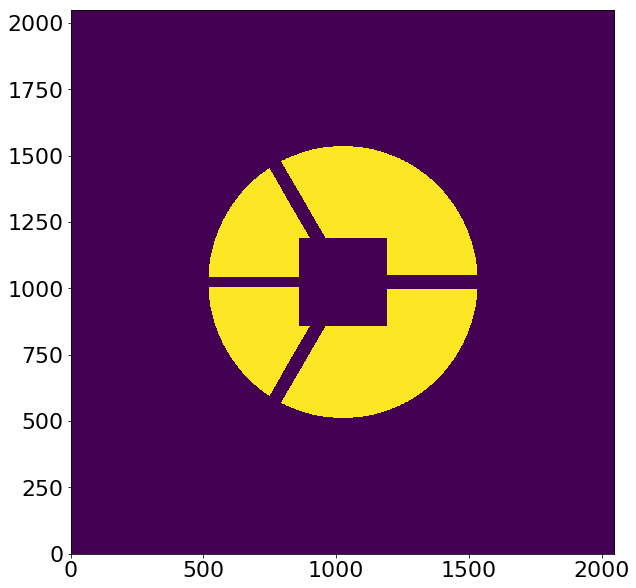

In [88]:
plt.figure(figsize=(10,10))
aperilluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'aperilluminated.npy') 
plt.imshow(aperilluminated,origin='lower')
aperilluminated.shape

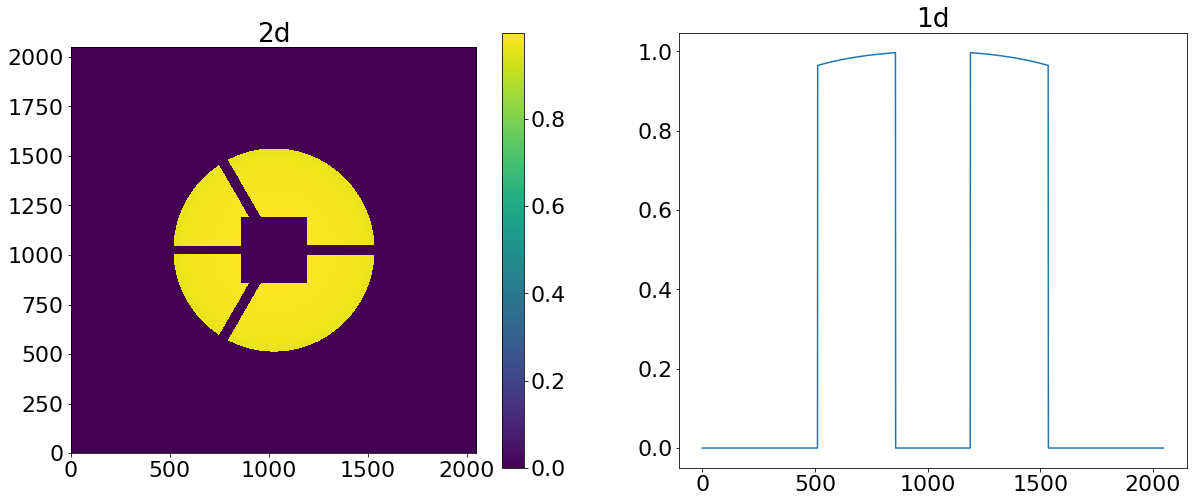

In [89]:
r=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy') 

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(r,origin='lower')
plt.colorbar()
plt.title('2d')

plt.subplot(122)
plt.plot(r[:,int(r.shape[0]/2+5)])
plt.title('1d')

## wavefront on the exit pupil

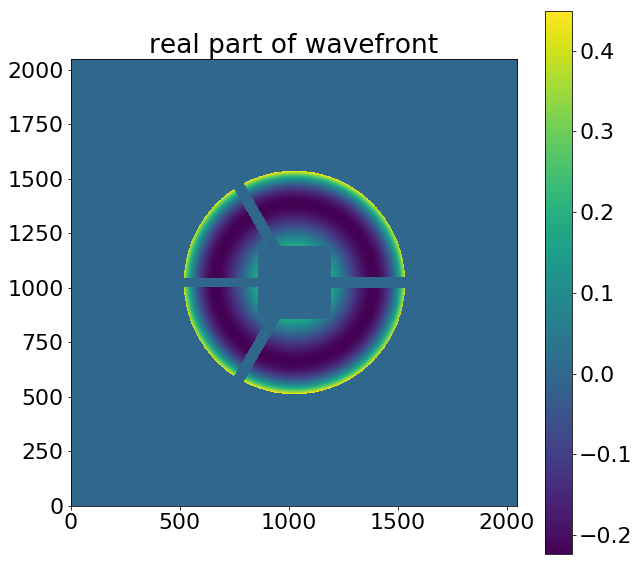

In [90]:
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
plt.figure(figsize=(10,10))
plt.imshow(np.real(wf_grid),origin='lower')
plt.title('real part of wavefront')
plt.colorbar()

(2048, 2048)

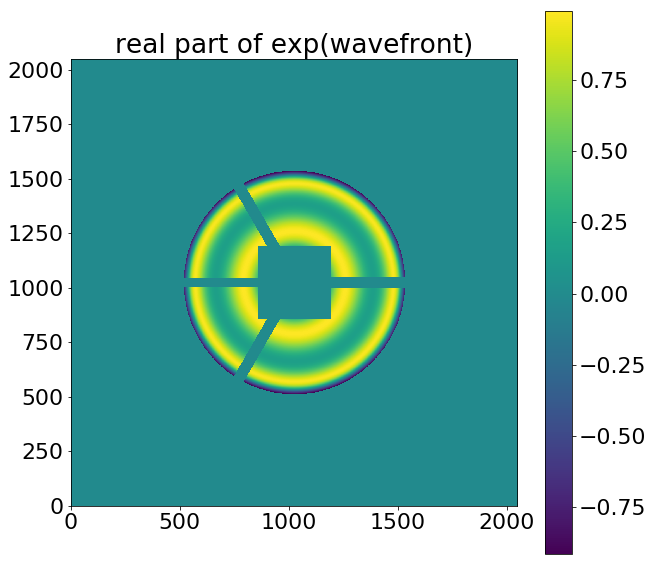

In [91]:
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')  
plt.figure(figsize=(10,10))
plt.title('real part of exp(wavefront)')
plt.imshow(np.real(expwf_grid),origin='lower')
plt.colorbar()
np.real(expwf_grid).shape

## single spot 

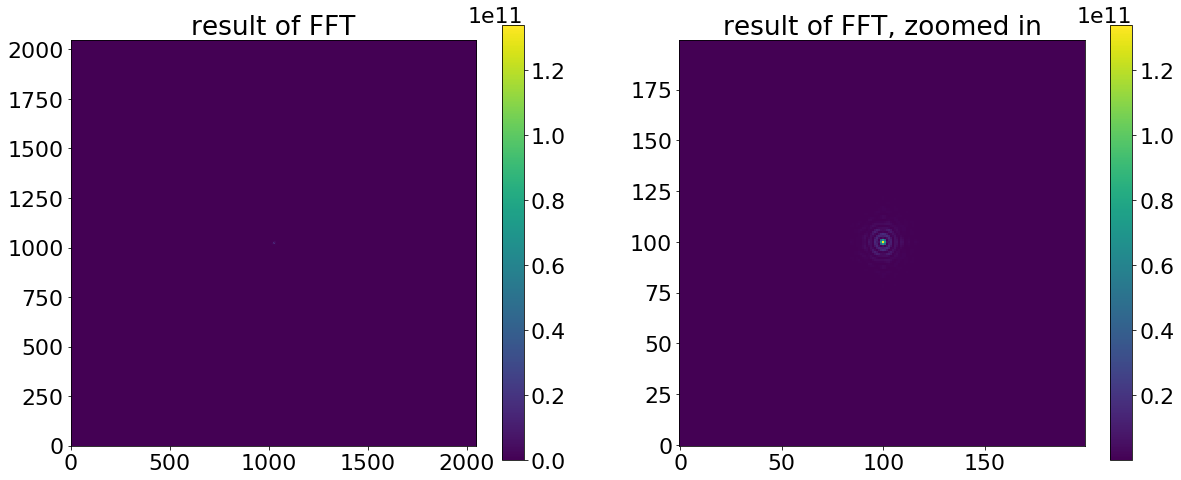

In [92]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower')
middleposition=int(optPsf.shape[0]/2)
plt.colorbar()
plt.title('result of FFT')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower')
plt.colorbar()
plt.title('result of FFT, zoomed in')

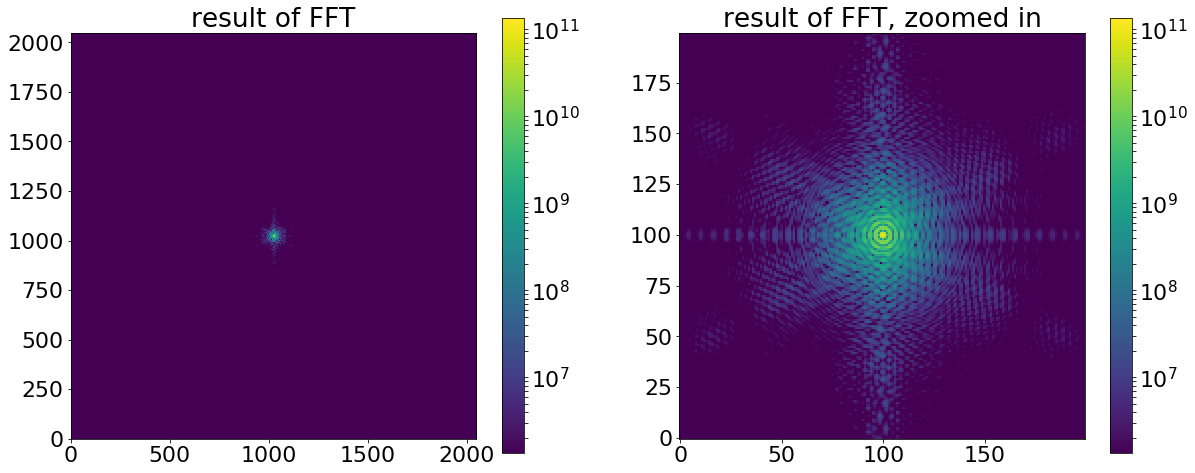

In [93]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
plt.colorbar()
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
plt.colorbar()
plt.title('result of FFT, zoomed in, log')

## spot convolved with fiber 

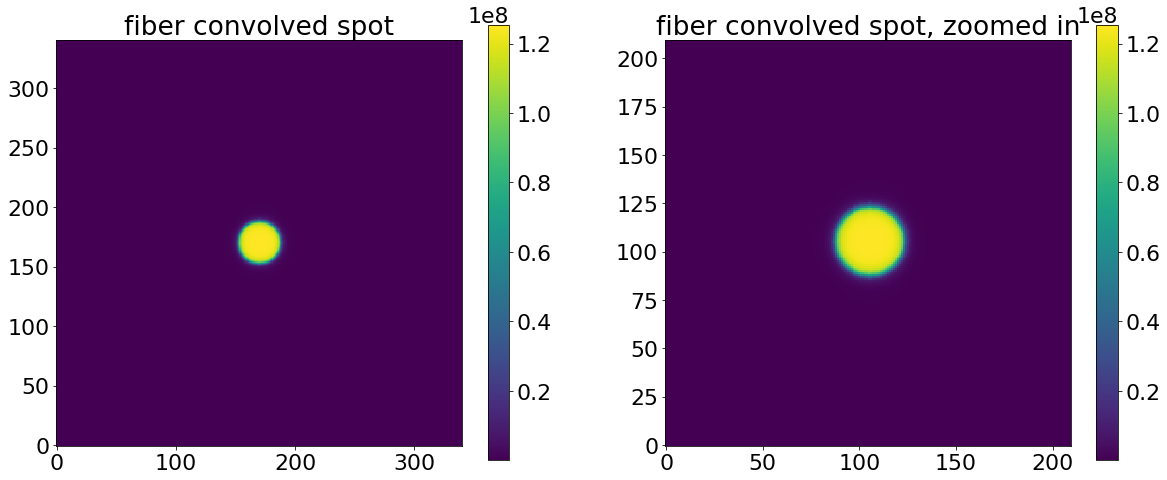

In [94]:
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')    
middleposition=int(optPsf_cut_fiber_convolved.shape[0]/2)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved,origin='lower')
plt.colorbar()
plt.title('fiber convolved spot')

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower')
plt.colorbar()
plt.title('fiber convolved spot, zoomed in')

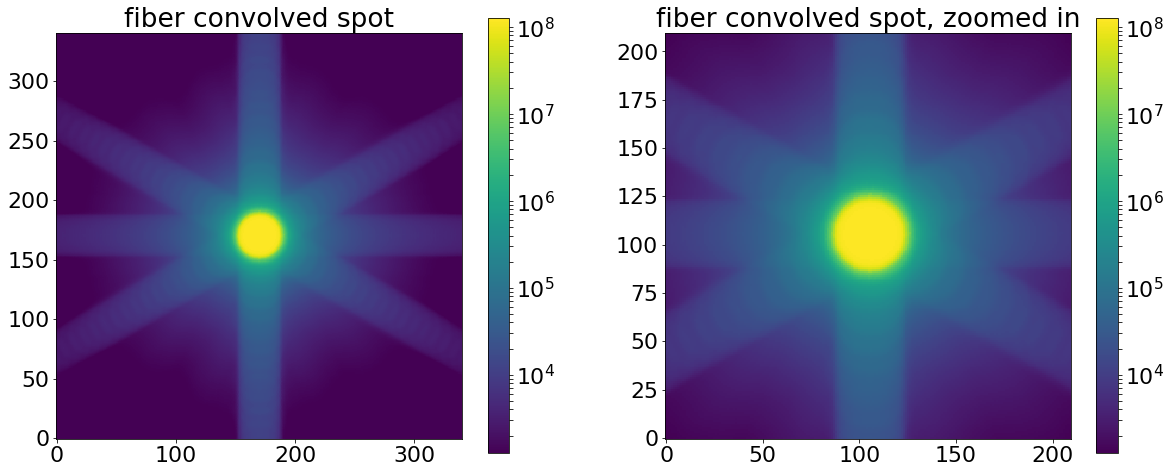

In [95]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved)/10**5)
plt.colorbar()
plt.title('fiber convolved spot, log')

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved)/10**5)
plt.colorbar()
plt.title('fiber convolved spot, zoomed in, log')

## spot convolved with fiber and pixel reponse

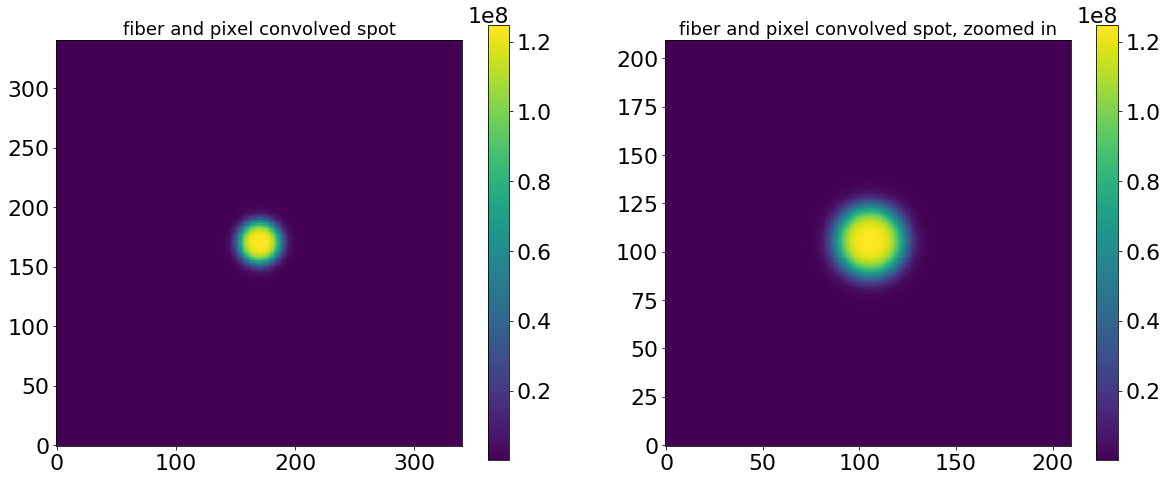

In [96]:
optPsf_cut_pixel_response_convolve=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')   
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_pixel_response_convolve,origin='lower')
plt.colorbar()
plt.title('fiber and pixel convolved spot', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_pixel_response_convolve[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower')
plt.colorbar()
plt.title('fiber and pixel convolved spot, zoomed in', fontsize=18)

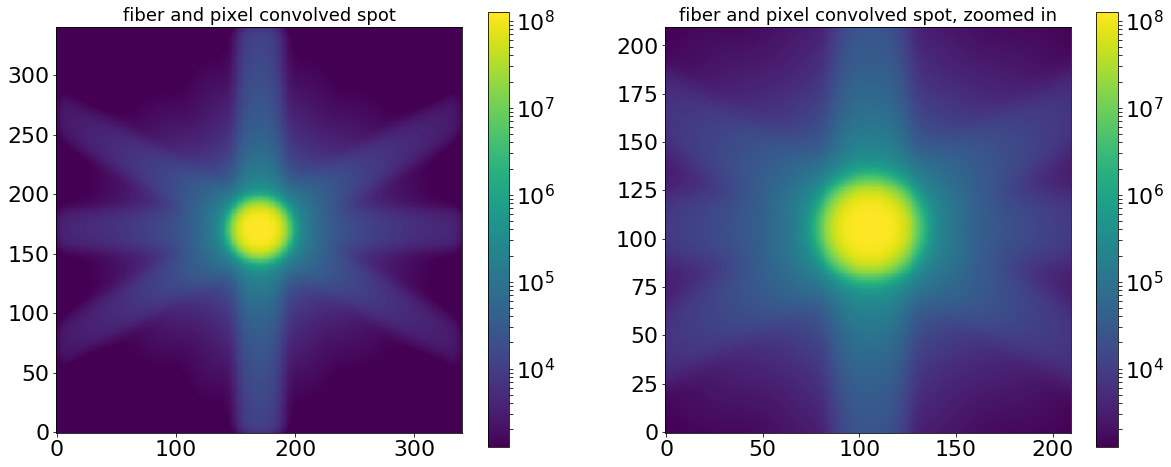

In [97]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_pixel_response_convolve,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_pixel_response_convolve)/10**5)
plt.colorbar()
plt.title('fiber and pixel convolved spot, log', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_pixel_response_convolve[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_pixel_response_convolve)/10**5)
plt.colorbar()
plt.title('fiber and pixel convolved spot, zoomed in, log', fontsize=18)

## final result

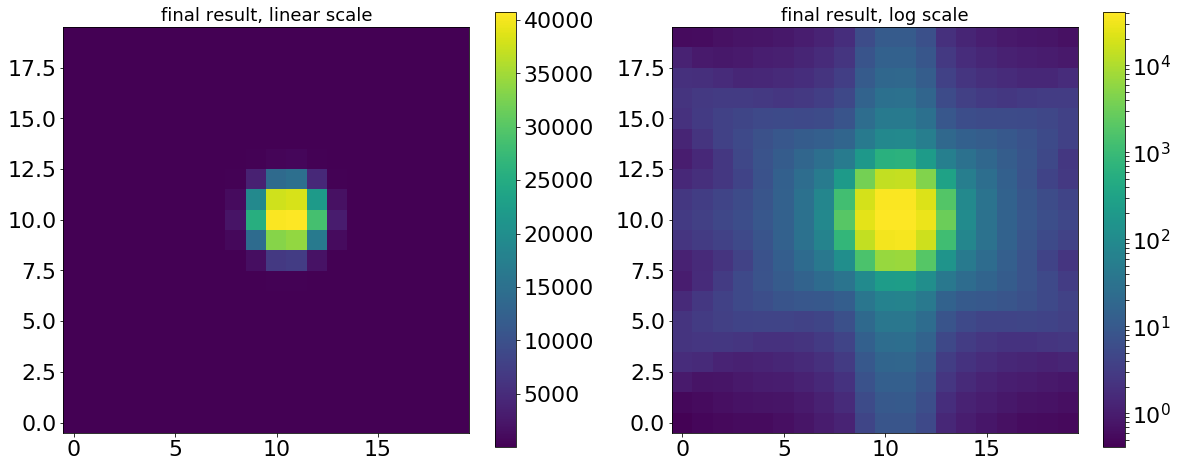

In [98]:
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')   


plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved_downsampled,origin='lower')
plt.colorbar()
plt.title('final result, linear scale', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved_downsampled,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved_downsampled)/10**5)
plt.colorbar()
plt.title('final result, log scale', fontsize=18)

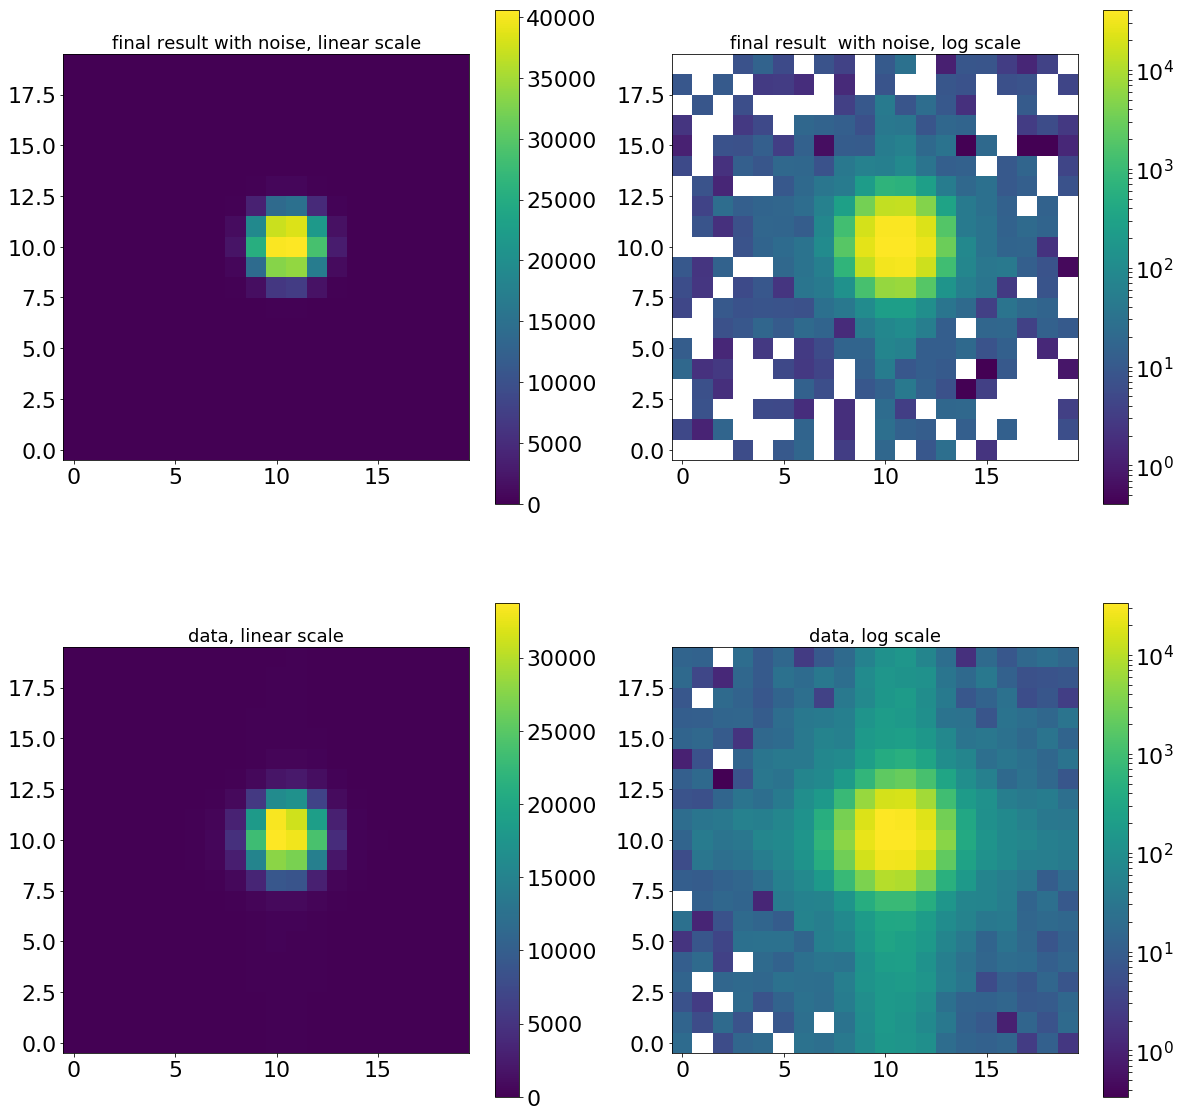

In [106]:
# this part adds noise to the perfect models

# NOTE that this is not a fit - the values we supplied above were generally ok values, but not exact fit to the data
# I show comparison to the data just for general sense 
# Also this data has not been cleaned in vertical direction, i.e., it still has contribution due to continuum

artifical_noise_data=np.zeros((var_image.shape[0],var_image.shape[1]))
for i in range(len(artifical_noise_data)):
    for j in range(len(artifical_noise_data)):
        artifical_noise_data[i][j]=np.random.normal(0,np.sqrt(var_image[i][j]))
        

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower')
plt.colorbar()
plt.title('final result with noise, linear scale', fontsize=18)

plt.subplot(222)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved_downsampled)/10**5)
plt.colorbar()
plt.title('final result  with noise, log scale', fontsize=18)        

plt.subplot(223)
plt.imshow(sci_image,origin='lower')
plt.colorbar()
plt.title('data, linear scale', fontsize=18)

plt.subplot(224)
plt.imshow(sci_image,origin='lower',norm=LogNorm(),vmin=np.max(sci_image)/10**5)
plt.colorbar()
plt.title('data, log scale', fontsize=18)    

## final result with arcsinh scaling 

In [121]:
# Create an ImageNormalize object
from astropy.visualization import ( AsinhStretch,
                                   ImageNormalize)

norm = ImageNormalize(sci_image, vmax=1000,
                      stretch=AsinhStretch())

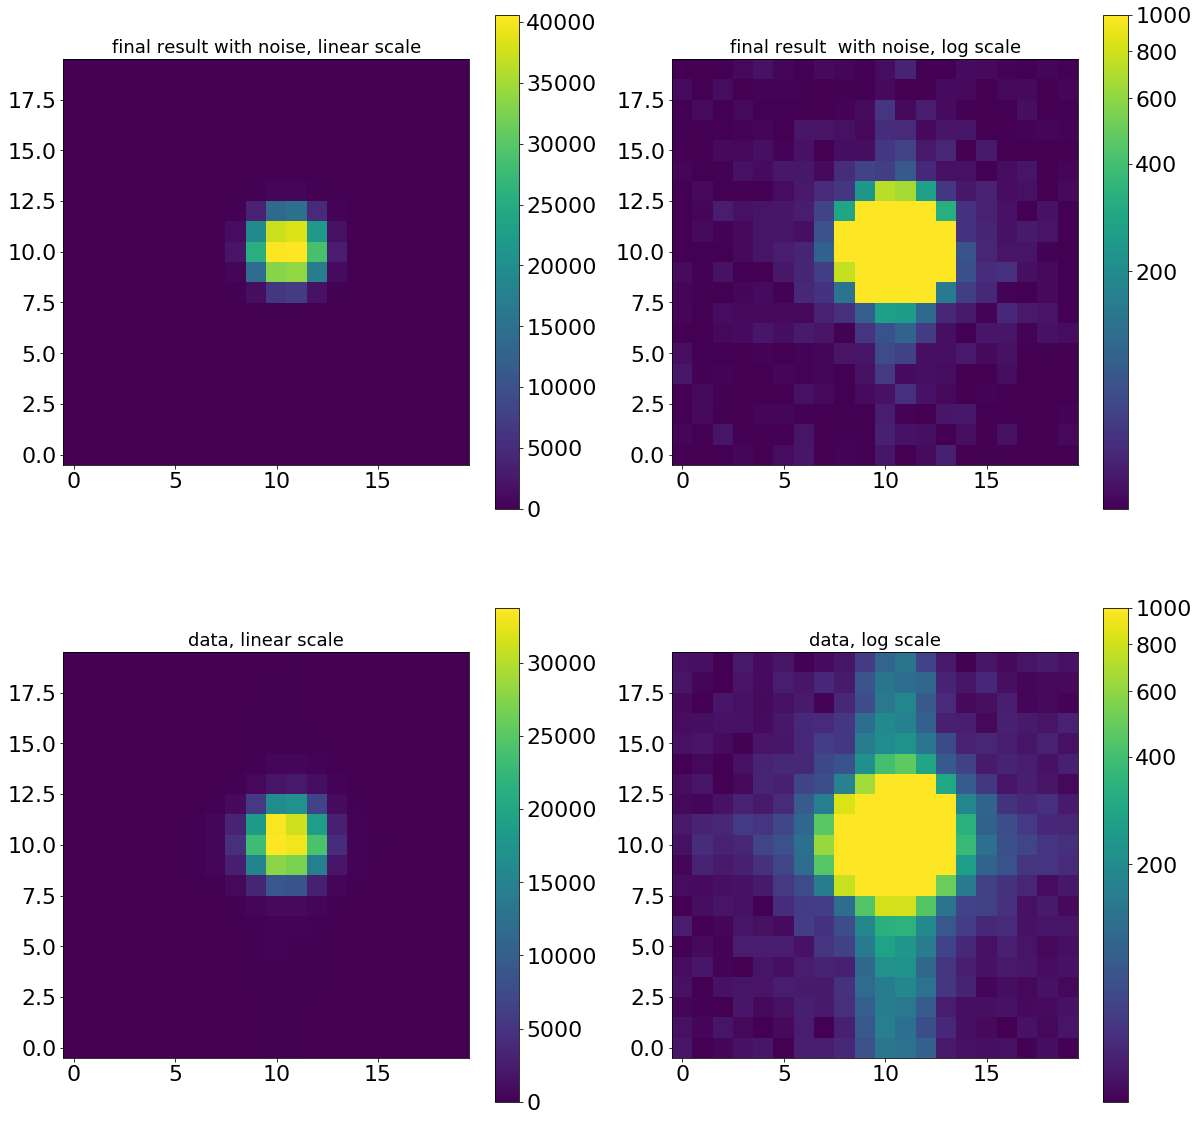

In [122]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower')
plt.colorbar()
plt.title('final result with noise, linear scale', fontsize=18)

plt.subplot(222)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower',norm=norm,vmin=np.max(optPsf_cut_fiber_convolved_downsampled)/10**5)
plt.colorbar()
plt.title('final result  with noise, log scale', fontsize=18)        

plt.subplot(223)
plt.imshow(sci_image,origin='lower')
plt.colorbar()
plt.title('data, linear scale', fontsize=18)

plt.subplot(224)
plt.imshow(sci_image,origin='lower', norm=norm,vmin=np.max(sci_image)/10**5)
plt.colorbar()
plt.title('data, log scale', fontsize=18)    

# check that scaling is ok with Zemax images

In [99]:
"""
This is to check if the size of the created images is consistent with Zemax
This image is created without obcuring structures (in both Zemax and this code) to ease comparison
"""


allparameters_proposal=np.array([-3.75,0.0,-0.021,0.0,-0.084,0.0,0.003,0.4705,
                                 0.0,0.00,0.0,0.0,0.00,0.0,
                                 0.0,0,
                                 0.0,0.00,1,0.0,
                                 0.999,0.45,1.0])
model(allparameters_proposal)

oversampling of optPSF is: 40
oversampling of optPsf_downsampled is: 10


-177969.80151523501

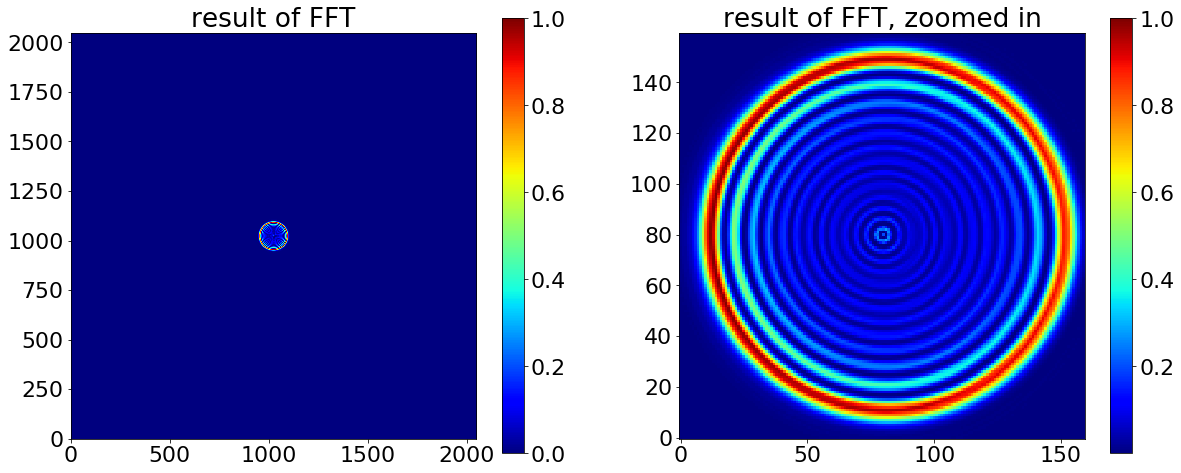

In [100]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
optPsf=optPsf/np.max(optPsf)

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',cmap='jet')
middleposition=int(optPsf.shape[0]/2)
plt.colorbar()
plt.title('result of FFT')

plt.subplot(122)
plt.imshow(np.flip(optPsf[middleposition-80:middleposition+80,middleposition-80:middleposition+80],axis=1),origin='lower',cmap='jet')
plt.colorbar()
plt.title('result of FFT, zoomed in')

In [101]:
# We see that the image on the right has diameter of roughly 160 pixels, which are 40 oversampled compared to real pixels
# Each real pixel is 15 microns
# Physical scale is therefore roughly 60 microns
160*15/40

60.0

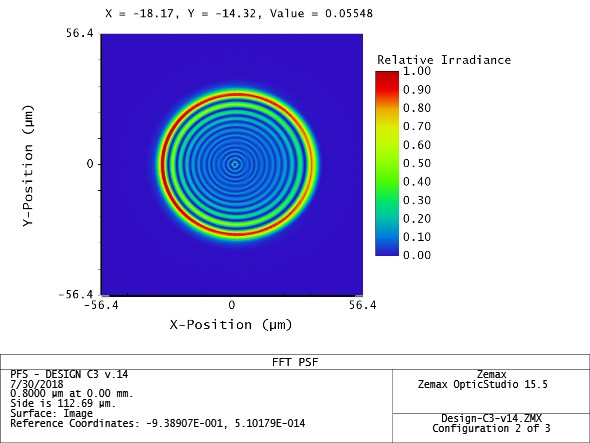

In [61]:
# Zemax image for same values of parameters - this image has somewhat larger diameter, around 70 microns, I need to investigate the reason for discprepancy
# I do not think that the size of discrepancy is enough to explain large differences in focused images
# Value used for this image are in "/Users/nevencaplar/Documents/PFS/Images/Jul25/ZemaxImages/ZernikeForDefocusedImage.txt" and one can verify they are same as above

from IPython.display import Image
from IPython.core.display import HTML 
Image("/Users/nevencaplar/Documents/PFS/Images/Jul25/ZemaxImages/DefocusedImage.jpg")

# Few Images showing how optical PSF results change when changing parameters

## Adding astigmatism (Z5 and Z6)

In [144]:
allparameters_proposal=np.array([0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.55,0.1,
                                 0.0,0.00,0.99,0.0,
                                 1.0,0.45,1.0])

model(allparameters_proposal)

oversampling of optPSF is: 40
oversampling of optPsf_downsampled is: 10


-18199.883377188518

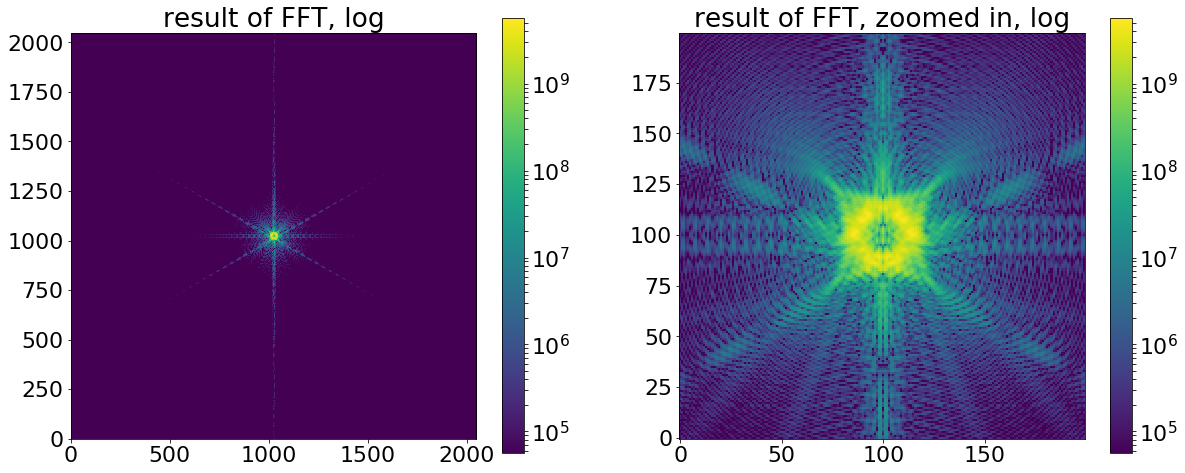

In [145]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
plt.colorbar()
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
plt.colorbar()
plt.title('result of FFT, zoomed in, log')

## Adding coma (Z7 and Z8)

In [146]:
allparameters_proposal=np.array([0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.55,0.1,
                                 0.0,0.00,0.99,0.0,
                                 1.0,0.45,1.0])

model(allparameters_proposal)

oversampling of optPSF is: 40
oversampling of optPsf_downsampled is: 10


-9551.432363476817

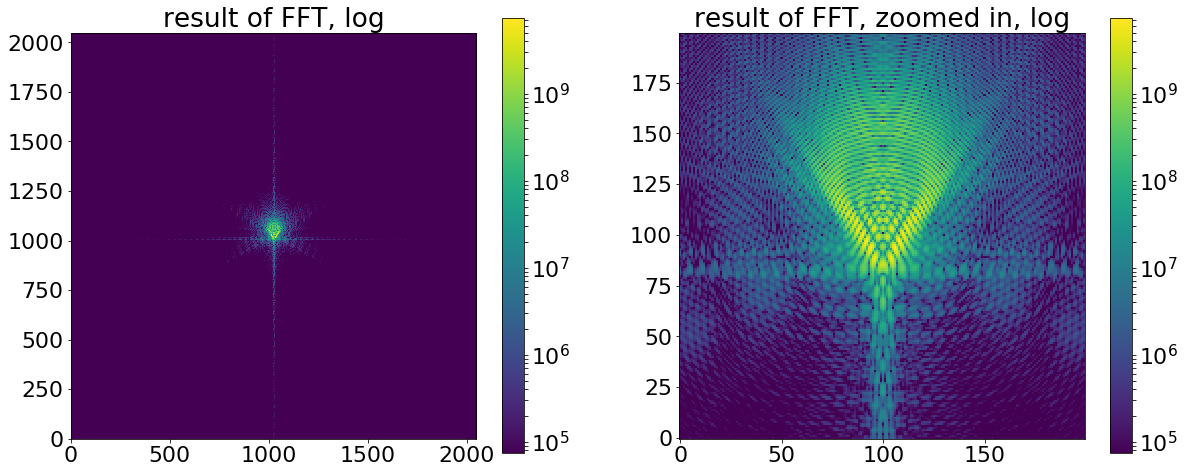

In [147]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
plt.colorbar()
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
plt.colorbar()
plt.title('result of FFT, zoomed in, log')

## Adding trefoil (Z9 and Z10)

In [138]:
allparameters_proposal=np.array([0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,
                                 0.65,0.1,0.0,0.0,0.08,0.0,
                                 0.55,0.1,
                                 0.0,0.00,0.99,0.0,
                                 1.0,0.45,1.0])

model(allparameters_proposal)

oversampling of optPSF is: 40
oversampling of optPsf_downsampled is: 10


-12617.002289993412

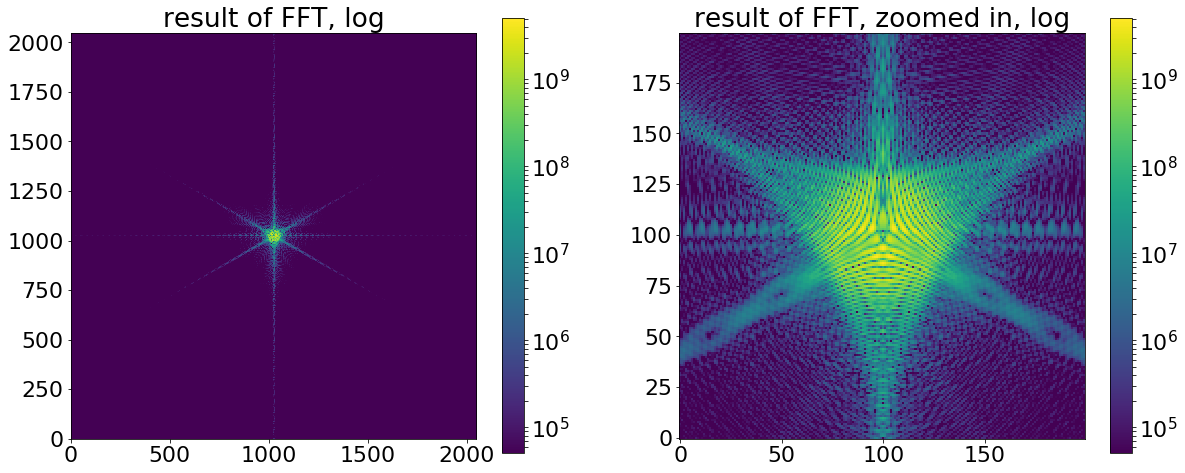

In [139]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
plt.colorbar()
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
plt.colorbar()
plt.title('result of FFT, zoomed in, log')